# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1jZQa1ljOZGhRrlMVpP3sHDiftC6IPmrw#scrollTo=vcp9Tu1Iwd4l

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [1]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:35tcmalloc: large alloc 1147494400 bytes == 0x39b7e000 @  0x7fcd46e1d615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:11:31tcmalloc: large alloc 1434370048 bytes == 0x7e1d4000 @  0x7fcd46e1d615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

In [2]:
!pip install torchtext==0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 14.9 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_dir = '/content/drive/My Drive/Colab Notebooks/MIE1517/Labs/Lab 4 - Recurrent Neural Networks/SMSSpamCollection'
ham = True
spam = True
for line in open(file_dir):
    if line.startswith('ham') and ham:
      ham = False
      print('Example of ham')
      print(line)
    if line.startswith('spam') and spam:
      spam = False
      print('Example of spam')
      print(line)
    if not ham and not spam:
      break

Example of ham
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Example of spam
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [6]:
ham_num = 0
spam_num = 0
for line in open(file_dir):
    if line.startswith('ham'):
      ham_num += 1
    if line.startswith('spam'):
      spam_num += 1

print('{} spam meesages are in the dataset'.format(spam_num))
print('{} ham meesages are in the dataset'.format(ham_num))

747 spam meesages are in the dataset
4827 ham meesages are in the dataset


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantage:

1. Every single word's vector can be formed even it is out-of-vocabulary words. On the other hand, word embedding can only handle those seen words.

2. It is good at fitting for misspelling words, emoticons, new words. It handles infrequent words better than word2vec embedding as later one suffers from lack of enough training opportunity for those rare words.

Disadvantage:
1. Word-based RNN display higher accuracy and lower computational cost than char-based RNN. This is because char-based RNN require much bigger hidden layer to successfully model long-term dependencies which means higher computational costs. 

2. In training, char-based RNN takes a longer path to propagate the error from the last time step back to the beginning, because the number of elements equals the number of characters in the sentence for char-based RNN rather than the number of words in the sentence.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [7]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [8]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset(file_dir, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

In [9]:
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [10]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

With class imbalanced data, classifiers tend to make biased learning model that has a poorer predictive accuracy over the minority classes compared to the majority classes. Hence, balanced training set can helpe increase the predictive accuracy over the miniority classes.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

text_field.vocab.stoi is a dictionary that assigns number to each character.

text_field.vocab.itos is a list of characters which are also keys in text_field.vocab.stoi

In [11]:
text_field.build_vocab(train)
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fbe72715dd0>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'h': 13,
             '0': 14,
             '.': 15,
             'd': 16,
             'c': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             'b': 25,
             '2': 26,
             'T': 27,
             '8': 28,
             'k': 29,
             'E': 30,
             'S': 31,
             '5': 32,
             'v': 33,
             'C': 34,
             'O': 35,
             'I': 36,
             '4': 37,
             '7': 38,
             'N': 39,
             '3':

In [12]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 '.',
 'd',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 'T',
 '8',
 'k',
 'E',
 'S',
 '5',
 'v',
 'C',
 'O',
 'I',
 '4',
 '7',
 'N',
 '3',
 'x',
 'A',
 '6',
 'R',
 ',',
 '!',
 'P',
 'W',
 '9',
 'U',
 'M',
 'L',
 'H',
 'D',
 'F',
 'G',
 'B',
 'Y',
 '/',
 "'",
 '?',
 '£',
 '-',
 '&',
 'X',
 ':',
 'z',
 '*',
 'V',
 'K',
 'j',
 ')',
 ';',
 'J',
 '+',
 '(',
 'Q',
 'q',
 '#',
 '"',
 '>',
 '@',
 '=',
 'Z',
 'ü',
 '<',
 '$',
 '%',
 'Ü',
 '‘',
 '\x92',
 '|',
 '[',
 ']',
 '\x93',
 '¡',
 '“',
 '…',
 '_',
 '’',
 'ú',
 '–',
 '\\',
 'é',
 '\t',
 '\n',
 '\x96',
 '^',
 '~',
 '\x91',
 '»',
 'É',
 'è',
 'ì',
 '┾',
 '〨',
 '鈥']

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

\<unk> represents means unknown word, a word that doesn't exist the the vocabulary set

\<pad> represents  zero inputs added at the end of sentence for shorter sequences

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [13]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [14]:
for i, batch in enumerate(train_iter):
    pad = (torch.full([32], len(batch.sms[0][0])) - batch.sms[1]).sum()
    print("Batch {}: The maximum length of the input sequence: {}. The number of <pad> tokens are used:".format(i+1, batch.sms[1][0]), int(pad))
    if i == 9:
        break

Batch 1: The maximum length of the input sequence: 147. The number of <pad> tokens are used: 27
Batch 2: The maximum length of the input sequence: 50. The number of <pad> tokens are used: 8
Batch 3: The maximum length of the input sequence: 29. The number of <pad> tokens are used: 13
Batch 4: The maximum length of the input sequence: 136. The number of <pad> tokens are used: 17
Batch 5: The maximum length of the input sequence: 64. The number of <pad> tokens are used: 51
Batch 6: The maximum length of the input sequence: 160. The number of <pad> tokens are used: 0
Batch 7: The maximum length of the input sequence: 158. The number of <pad> tokens are used: 0
Batch 8: The maximum length of the input sequence: 141. The number of <pad> tokens are used: 14
Batch 9: The maximum length of the input sequence: 148. The number of <pad> tokens are used: 1
Batch 10: The maximum length of the input sequence: 44. The number of <pad> tokens are used: 12


## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyRNN, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          h0 = h0.cuda()
          x = x.cuda()
        #############################################
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [15]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for batch in data:
        msg = batch.sms[0]
        label = batch.label
        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          msg = msg.cuda()
          label = label.cuda()
        #############################################
        output = model(msg)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += batch.label.shape[0]
    return correct / total

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [16]:
import matplotlib.pyplot as plt

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5, batch_size = 32):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    train_iter = torchtext.legacy.data.BucketIterator(train_loader,
                        batch_size=batch_size,
                        sort_key=lambda x: len(x.sms), 
                        sort_within_batch=True,        
                        repeat=False)
    valid_iter = torchtext.legacy.data.BucketIterator(valid_loader,
                        batch_size=batch_size,
                        sort_key=lambda x: len(x.sms),
                        sort_within_batch=True,
                        repeat=False)
    for epoch in range(num_epochs):
        for batch in train_iter:
            msg = batch.sms[0]
            label = batch.label
            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              msg = msg.cuda()
              label = label.cuda()
            #############################################
            optimizer.zero_grad()
            pred = model(msg)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_iter))
        valid_acc.append(get_accuracy(model, valid_iter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

CUDA is available!  Training on GPU ...
Epoch 1; Loss 0.636797; Train Acc 0.732878; Val Acc 0.726457
Epoch 2; Loss 0.340566; Train Acc 0.907015; Val Acc 0.908520
Epoch 3; Loss 0.263371; Train Acc 0.909515; Val Acc 0.948879
Epoch 4; Loss 0.424940; Train Acc 0.911181; Val Acc 0.947982
Epoch 5; Loss 0.305579; Train Acc 0.942176; Val Acc 0.942601
Epoch 6; Loss 0.388399; Train Acc 0.927345; Val Acc 0.937220
Epoch 7; Loss 0.054533; Train Acc 0.943676; Val Acc 0.944395
Epoch 8; Loss 0.248166; Train Acc 0.895684; Val Acc 0.949776
Epoch 9; Loss 0.044823; Train Acc 0.947009; Val Acc 0.949776
Epoch 10; Loss 0.165181; Train Acc 0.955007; Val Acc 0.939910
Epoch 11; Loss 0.130026; Train Acc 0.930345; Val Acc 0.904036
Epoch 12; Loss 0.224422; Train Acc 0.946342; Val Acc 0.939013
Epoch 13; Loss 0.281426; Train Acc 0.929512; Val Acc 0.966816
Epoch 14; Loss 0.574861; Train Acc 0.873688; Val Acc 0.949776
Epoch 15; Loss 0.094654; Train Acc 0.962506; Val Acc 0.943498
Epoch 16; Loss 0.375250; Train Acc 0.93

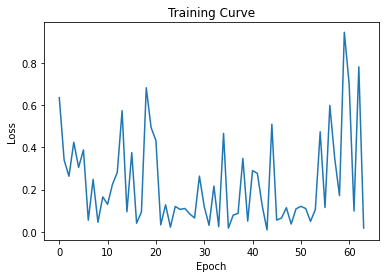

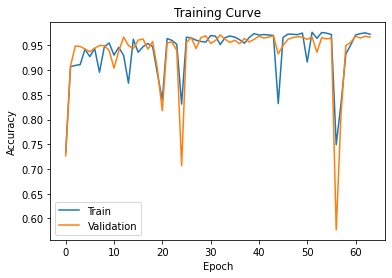

In [ ]:
model = MyRNN(len(text_field.vocab), len(text_field.vocab), 2)
if torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_network(model, train, valid, num_epochs=64, learning_rate=0.0001)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

1. Reduce epochs to 32, because the accuracy hasn't changed much after epoch 30, and there are more severe sudden drops in accuracy after epoch 30. Also, it can prevent overfitting

CUDA is available!  Training on GPU ...
Epoch 1; Loss 0.692128; Train Acc 0.678720; Val Acc 0.552466
Epoch 2; Loss 0.290967; Train Acc 0.876021; Val Acc 0.808969
Epoch 3; Loss 0.270953; Train Acc 0.902350; Val Acc 0.939910
Epoch 4; Loss 0.521625; Train Acc 0.906182; Val Acc 0.939910
Epoch 5; Loss 0.443964; Train Acc 0.838194; Val Acc 0.860987
Epoch 6; Loss 0.185612; Train Acc 0.930678; Val Acc 0.945291
Epoch 7; Loss 0.081829; Train Acc 0.946342; Val Acc 0.925561
Epoch 8; Loss 0.284414; Train Acc 0.945176; Val Acc 0.924664
Epoch 9; Loss 0.051633; Train Acc 0.950508; Val Acc 0.956951
Epoch 10; Loss 0.964930; Train Acc 0.920847; Val Acc 0.963229
Epoch 11; Loss 0.129292; Train Acc 0.952508; Val Acc 0.952466
Epoch 12; Loss 0.152960; Train Acc 0.952508; Val Acc 0.963229
Epoch 13; Loss 0.071891; Train Acc 0.955507; Val Acc 0.965919
Epoch 14; Loss 0.162022; Train Acc 0.961006; Val Acc 0.959641
Epoch 15; Loss 0.184836; Train Acc 0.961506; Val Acc 0.962332
Epoch 16; Loss 0.317454; Train Acc 0.96

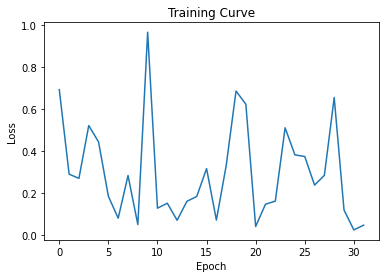

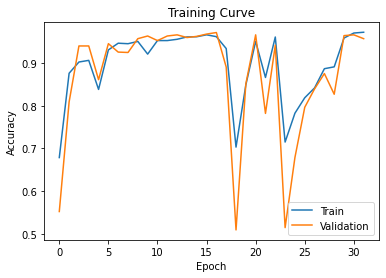

In [ ]:
model_MyRNN_ep = MyRNN(len(text_field.vocab), len(text_field.vocab), 2)
if torch.cuda.is_available():
  model_MyRNN_ep.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_network(model_MyRNN_ep, train, valid, num_epochs=32, learning_rate=0.0001)

2. Increase the learning rate to 0.005, to add reduce the chance of being stuck in the local minimum, and computationally more efficient.

CUDA is available!  Training on GPU ...
Epoch 1; Loss 0.057037; Train Acc 0.917014; Val Acc 0.921973
Epoch 2; Loss 0.454300; Train Acc 0.888019; Val Acc 0.914798
Epoch 3; Loss 0.565778; Train Acc 0.834028; Val Acc 0.804484
Epoch 4; Loss 0.188982; Train Acc 0.919347; Val Acc 0.966816
Epoch 5; Loss 0.175467; Train Acc 0.935511; Val Acc 0.959641
Epoch 6; Loss 0.658685; Train Acc 0.734544; Val Acc 0.756054
Epoch 7; Loss 0.663337; Train Acc 0.620397; Val Acc 0.650224
Epoch 8; Loss 0.603847; Train Acc 0.737544; Val Acc 0.782063
Epoch 9; Loss 0.521667; Train Acc 0.695884; Val Acc 0.659193
Epoch 10; Loss 0.480556; Train Acc 0.923679; Val Acc 0.923767
Epoch 11; Loss 0.223498; Train Acc 0.914181; Val Acc 0.854709
Epoch 12; Loss 0.056246; Train Acc 0.948175; Val Acc 0.959641
Epoch 13; Loss 0.718632; Train Acc 0.733378; Val Acc 0.670852
Epoch 14; Loss 0.201871; Train Acc 0.926846; Val Acc 0.888789
Epoch 15; Loss 0.236602; Train Acc 0.953508; Val Acc 0.927354
Epoch 16; Loss 0.393931; Train Acc 0.78

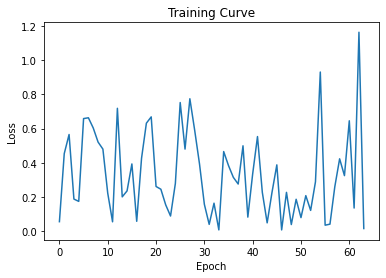

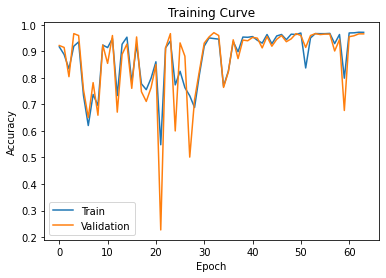

In [ ]:
model_MyRNN_lr = MyRNN(len(text_field.vocab), len(text_field.vocab), 2)
if torch.cuda.is_available():
  model_MyRNN_lr.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_network(model_MyRNN_lr, train, valid, num_epochs=64, learning_rate=0.0005)

3. Max-pooling the entire model's output array to help increase the accuracy by providing an abstracted form of the representation. As well, it reduces the computational cost.

In [17]:
class MyRNN_max(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyRNN_max, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          h0 = h0.cuda()
          x = x.cuda()
        #############################################
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [18]:
model_MyRNN_max = MyRNN_max(len(text_field.vocab), len(text_field.vocab), 2)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 0.698438; Train Acc 0.646559; Val Acc 0.371300
Epoch 2; Loss 0.604358; Train Acc 0.948675; Val Acc 0.908520
Epoch 3; Loss 0.406367; Train Acc 0.918014; Val Acc 0.940807
Epoch 4; Loss 0.219776; Train Acc 0.940177; Val Acc 0.961435
Epoch 5; Loss 0.232444; Train Acc 0.951175; Val Acc 0.955157
Epoch 6; Loss 0.509389; Train Acc 0.930012; Val Acc 0.970404
Epoch 7; Loss 0.115100; Train Acc 0.956841; Val Acc 0.954260
Epoch 8; Loss 0.073487; Train Acc 0.963006; Val Acc 0.955157
Epoch 9; Loss 0.023941; Train Acc 0.960007; Val Acc 0.966816
Epoch 10; Loss 0.136226; Train Acc 0.969338; Val Acc 0.964126
Epoch 11; Loss 0.020283; Train Acc 0.958840; Val Acc 0.944395
Epoch 12; Loss 0.081030; Train Acc 0.969672; Val Acc 0.963229
Epoch 13; Loss 0.032840; Train Acc 0.964006; Val Acc 0.968610
Epoch 14; Loss 0.105356; Train Acc 0.969172; Val Acc 0.971300
Epoch 15; Loss 0.144971; Train Acc 0.970672; Val Acc 0.961435
Epoch 16; Loss 0.293308; Train Acc 0.97

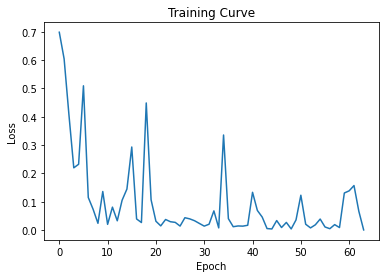

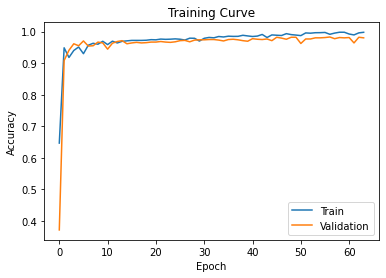

In [ ]:
model_MyRNN_max = MyRNN_max(len(text_field.vocab), len(text_field.vocab), 2)
if torch.cuda.is_available():
  model_MyRNN_max.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_network(model_MyRNN_max, train, valid, num_epochs=64, learning_rate=0.0001)

4. Concatenate the max-pooling and average-pooling of the RNN outputs to not just select the outstanding features(max-pooling), but also get the smooth repesentation of all features in the output (average-pooling). 

In [ ]:
class MyRNN_max_mean(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyRNN_max_mean, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          h0 = h0.cuda()
          x = x.cuda()
        #############################################
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

CUDA is available!  Training on GPU ...
Epoch 1; Loss 0.705604; Train Acc 0.542243; Val Acc 0.188341
Epoch 2; Loss 0.662050; Train Acc 0.743209; Val Acc 0.910314
Epoch 3; Loss 0.358654; Train Acc 0.935844; Val Acc 0.946188
Epoch 4; Loss 0.344223; Train Acc 0.928679; Val Acc 0.963229
Epoch 5; Loss 0.270857; Train Acc 0.935844; Val Acc 0.957848
Epoch 6; Loss 0.213308; Train Acc 0.941676; Val Acc 0.957848
Epoch 7; Loss 0.130649; Train Acc 0.949508; Val Acc 0.947085
Epoch 8; Loss 0.095339; Train Acc 0.951008; Val Acc 0.958744
Epoch 9; Loss 0.035462; Train Acc 0.945509; Val Acc 0.970404
Epoch 10; Loss 0.172102; Train Acc 0.954008; Val Acc 0.962332
Epoch 11; Loss 0.022147; Train Acc 0.958174; Val Acc 0.947085
Epoch 12; Loss 0.172282; Train Acc 0.961506; Val Acc 0.951570
Epoch 13; Loss 0.085141; Train Acc 0.963506; Val Acc 0.959641
Epoch 14; Loss 0.077058; Train Acc 0.959340; Val Acc 0.965919
Epoch 15; Loss 0.144886; Train Acc 0.965672; Val Acc 0.956951
Epoch 16; Loss 0.233431; Train Acc 0.96

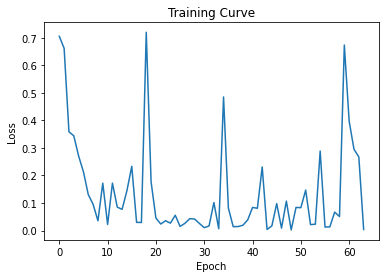

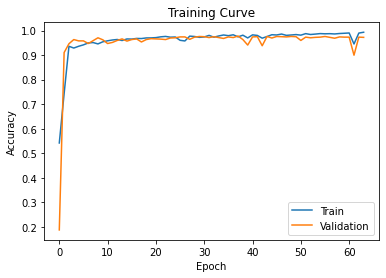

In [ ]:
model_MyRNN_max_mean = MyRNN_max_mean(len(text_field.vocab), len(text_field.vocab), 2)
if torch.cuda.is_available():
  model_MyRNN_max_mean.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_network(model_MyRNN_max_mean, train, valid, num_epochs=64, learning_rate=0.0001)

The best validation accuracy is 0.980269 from Max-pooling RNN model with epochs 64 and learning rate 0.0001.

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [19]:
def error_rate(data, model, batch_size=32):
    # Create a Dataset of only spam validation examples
    valid_spam = torchtext.legacy.data.Dataset(
        [e for e in valid.examples if e.label == 1],
        valid.fields)
    # Create a Dataset of only non-spam validation examples
    valid_ham = torchtext.legacy.data.Dataset(
        [e for e in data.examples if e.label == 0],
        data.fields)

    spam_loader = torchtext.legacy.data.BucketIterator(valid_spam,
                                        batch_size=batch_size,
                                        sort_key=lambda x: len(x.sms), 
                                        sort_within_batch=True,        
                                        repeat=False)
    ham_loader = torchtext.legacy.data.BucketIterator(valid_ham,
                                        batch_size=batch_size,
                                        sort_key=lambda x: len(x.sms), 
                                        sort_within_batch=True,        
                                        repeat=False)
  
    fal_pos_rate = 1 - get_accuracy(model, ham_loader)
    fal_neg_rate = 1 - get_accuracy(model, spam_loader)
    print('The false positive rate is ', fal_pos_rate)
    print('Th false negative rate is ', fal_neg_rate)

In [ ]:
error_rate(valid, model_MyRNN_max)

The false positive rate is  0.007322175732217606
Th false negative rate is  0.08805031446540879


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

Impact of false positive:

Classify non-spam messages as spam messages. Higher rate, more important messages being classified as spam messages, people miss out important messages that they neeed to receive.

Impact of false negative:

Classify spam messages as non-spam messages. Higher rate, more spam messages being classified as non-spam messages, make people confusing whether to trust it or not.



## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_loader = torchtext.legacy.data.BucketIterator(test,
                            batch_size=32,
                            sort_key=lambda x: len(x.sms), 
                            sort_within_batch=True,        
                            repeat=False) 
print("Test accuracy:", get_accuracy(model_MyRNN_max, test_loader))

Test accuracy: 0.9775583482944344


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
error_rate(test, model_MyRNN_max)

The false positive rate is  0.016511867905056765
Th false negative rate is  0.08805031446540879


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [20]:
msg = "machine learning is sooo cool!"

def spam_pred(msg, model):
  token = []
  for i in msg:
      token.append(torch.tensor(text_field.vocab.stoi[i]))
  k = torch.stack(token).unsqueeze_(0)
  softmax = nn.Softmax(dim=1)
  prob = softmax(model(k))[0]
  return prob

In [ ]:
print('The proability of this message is spam message is ', spam_pred(msg, model_MyRNN_max)[1].item())

The proability of this message is spam message is  0.011002445593476295


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam is a difficult task, consider that a lot data is needed to feed the machine, so it can understand the pattern of sequence in spam message. Also, considering spam message also evolves as time passes, multiple metrics needs to be updated and implemented and new data needs to be collected.

A baseline model would be a simple logistic regression model with data being one-hot-encoding transformed

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [21]:
# install relevant libraries
!pip install spacy==2.3.5
!pip install fastai==1.0.61

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 10.6 MB/s 
     |████████████████████████████████| 208 kB 70.3 MB/s 
     |████████████████████████████████| 1.0 MB 60.3 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.5
    Uninstalling srsly-2.4.5:
      Successfully uninstalled srsly-2.4.5
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.3
    Uninstalling spacy-3.4.3:
      Successfully uninstalled spacy-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [22]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [23]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-11-22 04:15:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   334KB/s    in 0.6s    

2022-11-22 04:15:11 (334 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [24]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [26]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [27]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [28]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [29]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when Ryan has recently wanted to sit in a car
The problem usually starts when 
  If , in the case of the
The problem usually starts when a police car is already off the ground , but
The problem usually starts when it becomes a public news news . a then -
The problem usually starts when the very end is called . This is in


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [30]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.553376,3.853791,0.300000,00:02
1,4.820383,4.007055,0.271429,00:02
2,4.379030,3.881753,0.257143,00:02
3,4.065218,3.832055,0.271429,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.574463,3.777923,0.285714,00:02
1,3.552554,3.723692,0.314286,00:02
2,3.488541,3.729576,0.271429,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.417027,3.737947,0.285714,00:02
1,3.387839,3.735439,0.285714,00:02
2,3.358741,3.727376,0.257143,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.310079,3.743547,0.257143,00:03
1,3.291249,3.723637,0.271429,00:03
2,3.252733,3.720690,0.257143,00:03


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [31]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [32]:
data_clas.show_batch()

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good boyfriend < #,ham
"xxbos xxmaj indians r poor but xxmaj india is not a poor country . xxmaj says one of the swiss bank xxunk . xxmaj he says that "" < # > xxunk crore "" of xxmaj indian money is xxunk in swiss banks which can be used for ' xxunk ' budget for < # > yrs . xxmaj can give < # > crore xxunk to all xxmaj indians",ham
"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < xxup decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : xxmaj sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - xxmaj maid",ham
"xxbos xxmaj good evening xxmaj sir , hope you are having a nice day . i wanted to bring it to your notice that i have been late in paying rent for the past few months and have had to pay a $ < # > charge . i felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that 's",ham


In [33]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [34]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 3.63E-02


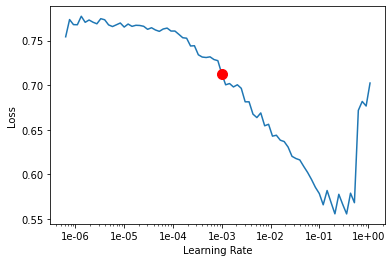

In [35]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [36]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.385632,0.077828,0.977273,00:03
1,0.190206,0.076921,0.980861,00:03
2,0.114654,0.069584,0.982057,00:03
3,0.086208,0.073147,0.985048,00:03
4,0.075583,0.087191,0.980861,00:03


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

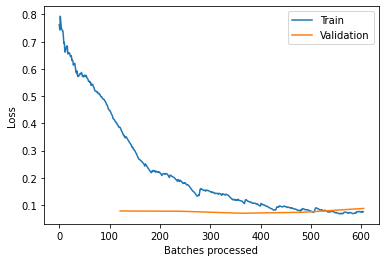

In [37]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.45E-04


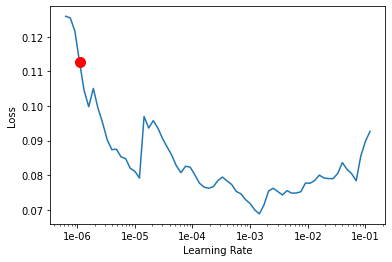

In [38]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [39]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([0.9989, 0.0011]))

In [40]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(0), tensor(0), tensor([0.7487, 0.2513]))

Next we will evaluate on all of our validation data.

In [41]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [42]:
def data_conver(data):
  label, msg = [], []
  for i in range(len(data)):
    label.append(0 if data[i].label == 0 else 1)
    msg.append(data[i].sms)
    
  df = pd.DataFrame({'target': label, 'text': msg})
  return df

df_trn = data_conver(train)
df_val = data_conver(valid)
df_test = data_conver(test)

In [43]:
eval_data = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, test_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)
learn_classifier.data = eval_data
test_pred, test_label=learn_classifier.get_preds(ds_type=DatasetType.Test, ordered=True)
test_pred = torch.argmax(test_pred, dim=1)    
accuracy = np.mean([i == k for i, k in zip(test_pred, df_test['target'].values)])

print('Accuracy on testing dataset: ',accuracy)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Accuracy on testing dataset:  0.9721723518850988


### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def con_mat(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix for ULMFiT model: 


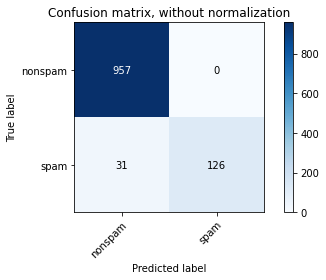

In [49]:
print('Confusion matrix for ULMFiT model: ')
con_mat(df_test['target'].values,test_pred, classes=['nonspam','spam'])
plt.show()

Confusion matrix for RNN model: 


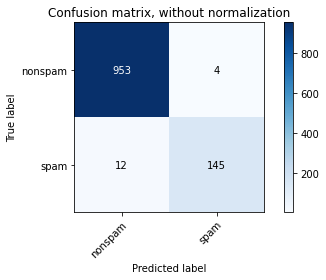

In [54]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), 
                    sort_within_batch=True,        
                    repeat=False) 
labels = []
preds = []
for msg, label in test_iter:
    msg = msg[0]
    #############################################
    #To Enable GPU Usage
    if torch.cuda.is_available():
      msg = msg.cuda()
      label = label.cuda()
    #############################################
    output = model_MyRNN_max(msg)
    pred = output.max(1, keepdim=True)[1]
    labels.append(label.cpu().detach().numpy())
    preds.append(pred.cpu().detach().numpy())

labels = np.concatenate(labels).ravel()
preds = np.concatenate(preds).ravel()


print('Confusion matrix for RNN model: ')
con_mat(labels, preds, classes=['nonspam','spam'])
plt.show()

ULMFiT model is better at detecting nonspam message with lower FPR, while my RNN_max-pooling model is better at detecting spam message with lower FNR. 

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [55]:
probs = learn_classifier.predict('machine learning is sooo cool!')

In [56]:
print('The probablity this message is spam: {}%'.format(probs[2][1]*100))

The probablity this message is spam: 1.1118834152001877e-11%


### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [57]:
def eval_spam(msg):
    probs = learn_classifier.predict(msg)[2][1].item()
    print('Probability of ULMFiT on spam message: {}'.format(probs))

    rnn_probs = spam_pred(msg, model_MyRNN_max)
    rnn_prob = rnn_probs[1].cpu().detach().numpy()
    print('Probability of RNN on spam message: {}'.format(rnn_prob))

In [58]:
spam_lst = ["Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/123456 tp claim now",
       "Hello, your FEDDEX package with tracking code DZ-8342-FY34 is waiting for you to set delivery preference: c4lrs.info/GM08s43vz1",
       "Amazon is sending you a refunding of $32.64. Please reply with your bank account and routing number to receive your refund.",
       "Wells Fargo Bank: Your account is temporarily locked. Please log in at http://goo.gl/2a234 to secure your account",
       "Your IRS tax refund is pending acceptance. Must accept within 24 hours: http://bit.ly/sdfsdf"
      ]

In [59]:
for i in spam_lst:
  eval_spam(i)

Probability of ULMFiT on spam message: 0.9381364583969116
Probability of RNN on spam message: 0.9980781078338623
Probability of ULMFiT on spam message: 0.5382256507873535
Probability of RNN on spam message: 0.9964069724082947
Probability of ULMFiT on spam message: 0.15373805165290833
Probability of RNN on spam message: 0.007640365976840258
Probability of ULMFiT on spam message: 0.6529828310012817
Probability of RNN on spam message: 0.9918527007102966
Probability of ULMFiT on spam message: 0.4966866970062256
Probability of RNN on spam message: 0.977655291557312


Overall, the RNN_max pooling model perform bettter with higher accuracy.

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [61]:
def eval_ham(msg):
    probs = learn_classifier.predict(msg)[2][0].item()
    print('Probability of ULMFiT on ham message: {}'.format(probs))

    rnn_probs = spam_pred(msg, model_MyRNN_max)
    rnn_prob = rnn_probs[0].cpu().detach().numpy()
    print('Probability of RNN on ham message: {}'.format(rnn_prob))

In [66]:
ham_lst = ["We’re wishing you the best of luck in the next step of your career.",
           "Thanks for choosing Mantle Hotels. We hope you enjoyed your stay. Please let us know how we did so we can serve you better",
           "Thank you for bringing your unrelenting joy to work every day. Your smile was contagious, and I’ll try to hold onto to it in future meetings.",
          "Hi! Thanks for stopping by today. We’d appreciate it if you took a moment to tell us what you like about our services and how we can improve.",
          "Thanks for patronizing our jewelry store. How would you rate our service on a scale of 1-10. Kindly reply to this message with your honest answer."
      ]

In [67]:
for i in ham_lst:
  eval_ham(i)

Probability of ULMFiT on ham message: 0.9993333220481873
Probability of RNN on ham message: 0.9967831373214722
Probability of ULMFiT on ham message: 0.9567344188690186
Probability of RNN on ham message: 0.9931790828704834
Probability of ULMFiT on ham message: 0.9999880790710449
Probability of RNN on ham message: 0.998542308807373
Probability of ULMFiT on ham message: 0.9900919795036316
Probability of RNN on ham message: 0.9925790429115295
Probability of ULMFiT on ham message: 0.7611426711082458
Probability of RNN on ham message: 0.9569676518440247


Both models perform very badly at recognizing nonspam emails that are actually customer surveys.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook TUT_4B_Generative_RNN.ipynb to html
[NbConvertApp] Writing 602750 bytes to TUT_4B_Generative_RNN.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus